<a href="https://colab.research.google.com/github/a1441/BART_Code/blob/main/BART_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, HistGradientBoostingClassifier,StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

# Data

In [ ]:
df_1 = pd.read_excel(r'/content/drive/MyDrive/risktaskResults (1).xlsx', engine='openpyxl')
df_2 = pd.read_excel(r'/content/drive/MyDrive/risktaskResults-retest.xlsx', engine='openpyxl')
df_3 = pd.read_excel(r'/content/drive/MyDrive/risktaskResults.xlsx', engine='openpyxl')

# Data Exploration

In [ ]:
c = 'collected'

dc_1 = ((df_1.filter(regex='collected'))/0.25).fillna(0).astype(int)
dc_1.columns = [f'{c}_{x}'for x in range(1,51)]

dc_2 = (df_2.filter(regex = 'Collected')/0.25).fillna(0).astype(int)
dc_2.columns = [f'{c}_{x}'for x in range(1,51)]

dc_3 = (df_3.filter(regex = 'collected')/0.25).fillna(0).astype(int)
dc_3.columns = [f'{c}_{x}'for x in range(1,51)]

collected = pd.concat([dc_1,dc_2,dc_3])

In [ ]:
c = 'haveFallen'

dff_1 = ((df_1.filter(regex='haveFallen'))).fillna(0).astype(int)
dff_1.columns = [f'{c}_{x}'for x in range(1,51)]

dff_2 = (df_2.filter(regex = 'HaveFallen')).fillna(0).astype(int)
dff_2.columns = [f'{c}_{x}'for x in range(1,51)]

dff_3 = (df_3.filter(regex = 'haveFallen')).fillna(0).astype(int)
dff_3.columns = [f'{c}_{x}'for x in range(1,51)]

fallen = pd.concat([dff_1,dff_2,dff_3])

In [ ]:
c = 'pumps'

dp_1 = ((df_1.filter(regex='pumps'))).fillna(0).astype(int)
dp_1.columns = [f'{c}_{x}'for x in range(1,51)]

dp_2 = (df_2.filter(regex = 'Pumps')).fillna(0).astype(int)
dp_2.columns = [f'{c}_{x}'for x in range(1,51)]

dp_3 = (df_3.filter(regex = 'pumps')).fillna(0).astype(int)
dp_3.columns = [f'{c}_{x}'for x in range(1,51)]

pumps = pd.concat([dp_1,dp_2,dp_3])

In [ ]:
c = 'total'

dt_1 = ((df_1.filter(regex='total'))/0.25).fillna(0).astype(int)
dt_1.columns = [f'{c}_{x}'for x in range(1,51)]

dt_2 = (df_2.filter(regex = 'Total')/0.25).fillna(0).astype(int)
dt_2.columns = [f'{c}_{x}'for x in range(1,51)]

dt_3 = (df_3.filter(regex = 'total')/0.25).fillna(0).astype(int)
dt_3.columns = [f'{c}_{x}'for x in range(1,51)]

totals = pd.concat([dt_1,dt_2,dt_3])

In [ ]:
c = 'turn'

dtt_1 = ((df_1.filter(regex='trialNumber'))).fillna(0).astype(int)+1
dtt_1.columns = [f'{c}_{x}'for x in range(1,51)]

dtt_2 = (df_2.filter(regex = 'TrialNumber')).fillna(0).astype(int)+1
dtt_2.columns = [f'{c}_{x}'for x in range(1,51)]

dtt_3 = (df_3.filter(regex = 'trialNumber')).fillna(0).astype(int)+1
dtt_3.columns = [f'{c}_{x}'for x in range(1,51)]

turns = pd.concat([dtt_1,dtt_2,dtt_3])

In [ ]:
c = 'bag'

dttb_1 = ((df_1.filter(regex='type'))).fillna(0).replace(0,3).astype(int)
dttb_1.columns = [f'{c}_{x}'for x in range(1,51)]

dttb_2 = (df_2.filter(regex = 'Type')).fillna(0).replace(0,3).astype(int)
dttb_2.columns = [f'{c}_{x}'for x in range(1,51)]

dttb_3 = (df_3.filter(regex = 'type')).fillna(0).replace(0,3).astype(int)
dttb_3.columns = [f'{c}_{x}'for x in range(1,51)]

baggs = pd.concat([dttb_1,dttb_2,dttb_3])

In [ ]:
df_start = pd.concat([collected, fallen, pumps, totals, turns, baggs], axis=1)
df_start.reset_index(drop=True,inplace=True)
df_start['Id'] = df_start.index

In [ ]:
df = df_start.copy()

In [ ]:
df

,collected_1,collected_2,collected_3,collected_4,collected_5,collected_6,collected_7,collected_8,collected_9,collected_10,...,bag_42,bag_43,bag_44,bag_45,bag_46,bag_47,bag_48,bag_49,bag_50,Id
0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,0
1,0,3,4,0,2,3,3,4,3,3,...,2,2,2,2,2,2,2,2,2,1
2,0,0,0,0,0,0,0,0,6,9,...,2,2,2,2,2,2,2,2,2,2
3,0,3,4,0,0,2,2,2,2,3,...,2,2,2,2,2,2,2,2,2,3
4,0,3,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,18,0,10,16,0,0,17,0,0,0,...,2,2,2,2,2,2,2,2,2,1265
1266,14,0,8,0,9,0,0,0,1,1,...,2,2,2,2,2,2,2,2,2,1266
1267,1,1,1,1,2,2,2,2,2,4,...,2,2,2,2,2,2,2,2,2,1267
1268,0,0,0,17,0,0,17,0,16,16,...,2,2,2,2,2,2,2,2,2,1268


In [ ]:
def generate_full_player_features(df_player_n):

    try:

        #single player sequence
        #generating 1 player (id) and all of its turns
        player_stratified = [df_player_n[['Id',f'collected_{t}', f'haveFallen_{t}', f'pumps_{t}', f'total_{t}', f'turn_{t}', f'bag_{t}']] for t in range(1,51)]
        #cleaning every turn in a uniform way that's ready for working with it
        player_turns_cleaned = [clean_turns(p) for p in player_stratified]
        #generating every single click based on an extrapolation
        player_clicks_generated = [generate_clicks(c) for c in player_turns_cleaned]
        one_player_raw = pd.concat(player_clicks_generated)
        one_player_raw.reset_index(drop=True, inplace=True)

        #dummifying all of the bags so we can calculate their cum scores
        one_player = pd.concat([one_player_raw,pd.get_dummies(data=one_player_raw, columns= ['bag'])[['bag_1','bag_2','bag_3']]], axis = 1)

        #cleaning data and feature engineering

        #total is the sum of the collected player amounts shifted 1 cell more so that the portfolio is available from next turn
        one_player['pumps_won'] = one_player.collected.cumsum().shift(1).fillna(0).astype(int)

        #cumulative clicks is the function of all turns (basically the index)
        one_player['cummulative_clicks'] = one_player.index.values+1

        #this is just to indicate if the player clicked on a single bag this turn, transformative field for other fields
        # one_player['click_single'] = -one_player['single_turn'] + 1

        #all clicks that the player effectively lost, this is havefallen * pumps cumsummed and shifted 1 role
        one_player['pumps_lost'] = (one_player['haveFallen'] * one_player['pumps']).cumsum().shift(1).fillna(0).astype(int)

        #all bags that the player won by having haveWon more than 0
        one_player['bags_won'] = one_player['haveWon'].cumsum().shift(1).fillna(0).astype(int)

        #all bags that the player won by having haveFallen more than 0
        one_player['bags_lost'] = one_player['haveFallen'].cumsum().shift(1).fillna(0).astype(int)

        #all bags that the player won by having haveFallen more than 0
        one_player['bags_auto_lost_won0'] = one_player['single_turn'].cumsum().shift(1).fillna(0).astype(int)

        #average pumps won/lost over bags that were won/lost
        one_player['avg_pumps_per_bag_won'] = (one_player['pumps_won'] / one_player['bags_won']).fillna(0) #classic kpi
        one_player['avg_pumps_per_bag_lost'] = (one_player['pumps_lost'] / one_player['bags_lost']).fillna(0)
        one_player['avg_pumps_per_bag'] = (one_player['cummulative_clicks'] / one_player['turn']).fillna(0)


        #seperate bags stats

        #####################################################################

        one_player['bag1_won'] = (one_player['haveWon']*one_player['bag_1'] ).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag1_lost'] = (one_player['haveFallen']*one_player['bag_1'] ).cumsum().shift(1).fillna(0).astype(int)

        one_player['bag1_win_vs_all'] = (one_player['bag1_won'] / one_player['bags_won']).fillna(0)
        one_player['bag1_loss_vs_all'] = (one_player['bag1_lost'] / one_player['bags_lost'] ).fillna(0)

        one_player['bag1_pumps_won'] = (one_player['bag_1'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag1_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_1']).cumsum().shift(1).fillna(0).astype(int)

        one_player['avg_pumps_per_bag1_won'] = (one_player['bag1_pumps_won'] / one_player['bag1_won']).fillna(0)
        one_player['avg_pumps_per_bag1_lost'] = (one_player['bag1_pumps_lost'] / one_player['bag1_lost']).fillna(0)

        one_player['cummulative_pumps_bag1'] = one_player['bag_1'].cumsum().fillna(0)

        #####################################################################

        one_player['bag2_won'] = (one_player['haveWon']*one_player['bag_2'] ).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag2_lost'] = (one_player['haveFallen']*one_player['bag_2'] ).cumsum().shift(1).fillna(0).astype(int)

        one_player['bag2_win_vs_all'] = (one_player['bag2_won'] / one_player['bags_won'] ).fillna(0)
        one_player['bag2_loss_vs_all'] = (one_player['bag2_lost'] / one_player['bags_lost'] ).fillna(0)

        one_player['bag2_pumps_won'] = (one_player['bag_2'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag2_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_2']).cumsum().shift(1).fillna(0).astype(int)

        one_player['avg_pumps_per_bag2_won'] = (one_player['bag2_pumps_won'] / one_player['bag2_won']).fillna(0)
        one_player['avg_pumps_per_bag2_lost'] = (one_player['bag2_pumps_lost'] / one_player['bag2_lost']).fillna(0)

        one_player['cummulative_pumps_bag2'] = one_player['bag_2'].cumsum().fillna(0)

        #####################################################################

        one_player['bag3_won'] = (one_player['haveWon']*one_player['bag_3'] ).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag3_lost'] = (one_player['haveFallen']*one_player['bag_3'] ).cumsum().shift(1).fillna(0).astype(int)

        one_player['bag3_win_vs_all'] = (one_player['bag3_won'] / one_player['bags_won']).fillna(0)
        one_player['bag3_loss_vs_all'] = (one_player['bag3_lost'] / one_player['bags_lost']).fillna(0)

        one_player['bag3_pumps_won'] = (one_player['bag_3'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag3_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_3']).cumsum().shift(1).fillna(0).astype(int)

        one_player['avg_pumps_per_bag3_won'] = (one_player['bag3_pumps_won'] / one_player['bag3_won']).fillna(0)
        one_player['avg_pumps_per_bag3_lost'] = (one_player['bag3_pumps_lost'] / one_player['bag3_lost']).fillna(0)

        one_player['cummulative_pumps_bag3'] = one_player['bag_3'].cumsum().fillna(0)

        return one_player

    except:
        print(f"{df_player_n.Id.values} is an invalid entry")

In [ ]:
#creating a temp df to create the clicks within turns
players = df.Id.unique()

def clean_turns (temp_dfs):
    """this function just cleans up the names of the columns and standartizes them"""

    nn_dfs = temp_dfs.copy()

    nn_dfs.columns = ['Id','collected','haveFallen','pumps','total','turn','bag']

    if nn_dfs.pumps.values[0] == 0:

        nn_dfs['single_turn'] = 1

    if nn_dfs.pumps.values[0] > 0:

        nn_dfs['single_turn'] = 0

    return nn_dfs

def generate_clicks(sample_dfs):

    nnn_dfs = sample_dfs.copy()

    """this function extrapolates all clicks from a turn if they are not 0, if 0 then returns the same df"""

    if nnn_dfs.single_turn.values[0] == 1:
        nnn_dfs['haveWon'] = 0
        nnn_dfs['haveFallen'] = 0
        return nnn_dfs

    if nnn_dfs.single_turn.values[0] == 0:
        #multiplies the df by the number of pumps
        nnn_dfs = pd.concat([nnn_dfs]*nnn_dfs.pumps.values[0]).reset_index(drop=True)
        #creates the numbers of pumps as range of all pumps + 1 at the end
        nnn_dfs['pumps'] = range(1,nnn_dfs.pumps.values[0]+1)
        #creates haveFallen as a range of 0 with the final results at the end
        nnn_dfs['haveFallen'] = [0]*(nnn_dfs.pumps.max()-1) + [nnn_dfs.haveFallen.max()]
        #creates haveWon as results of 0 ranges multiplied by the amoun of pumps and a negative havefallen + 1
        nnn_dfs['haveWon'] = [0]*(nnn_dfs.pumps.max()-1) + [-nnn_dfs.haveFallen.max()+1]
        #creates the collected as range of 0 with the final results at the end ... this needs to be further moved one row
        nnn_dfs['collected'] = [0]*(nnn_dfs.pumps.max()-1) + [(-nnn_dfs.haveFallen.max()+1)*nnn_dfs['collected'].max()]
        return nnn_dfs


In [ ]:
def generate_full_player_features(df_player_n):

    try:

        #single player sequence
        #generating 1 player (id) and all of its turns
        player_stratified = [df_player_n[['Id',f'collected_{t}', f'haveFallen_{t}', f'pumps_{t}', f'total_{t}', f'turn_{t}', f'bag_{t}']] for t in range(1,51)]
        #cleaning every turn in a uniform way that's ready for working with it
        player_turns_cleaned = [clean_turns(p) for p in player_stratified]
        #generating every single click based on an extrapolation
        player_clicks_generated = [generate_clicks(c) for c in player_turns_cleaned]
        one_player_raw = pd.concat(player_clicks_generated)
        one_player_raw.reset_index(drop=True, inplace=True)

        #dummifying all of the bags so we can calculate their cum scores
        one_player = pd.concat([one_player_raw,pd.get_dummies(data=one_player_raw, columns= ['bag'])[['bag_1','bag_2','bag_3']]], axis = 1)

        #cleaning data and feature engineering

        #total is the sum of the collected player amounts shifted 1 cell more so that the portfolio is available from next turn
        one_player['pumps_won'] = one_player.collected.cumsum().shift(1).fillna(0).astype(int)

        #cumulative clicks is the function of all turns (basically the index)
        one_player['cummulative_clicks'] = one_player.index.values+1

        #this is just to indicate if the player clicked on a single bag this turn, transformative field for other fields
        # one_player['click_single'] = -one_player['single_turn'] + 1

        #all clicks that the player effectively lost, this is havefallen * pumps cumsummed and shifted 1 role
        one_player['pumps_lost'] = (one_player['haveFallen'] * one_player['pumps']).cumsum().shift(1).fillna(0).astype(int)

        #all bags that the player won by having haveWon more than 0
        one_player['bags_won'] = one_player['haveWon'].cumsum().shift(1).fillna(0).astype(int)

        #all bags that the player won by having haveFallen more than 0
        one_player['bags_lost'] = one_player['haveFallen'].cumsum().shift(1).fillna(0).astype(int)

        #all bags that the player won by having haveFallen more than 0
        one_player['bags_auto_lost_won0'] = one_player['single_turn'].cumsum().shift(1).fillna(0).astype(int)

        #average pumps won/lost over bags that were won/lost
        one_player['avg_pumps_per_bag_won'] = (one_player['pumps_won'] / one_player['bags_won']).fillna(0) #classic kpi
        one_player['avg_pumps_per_bag_lost'] = (one_player['pumps_lost'] / one_player['bags_lost']).fillna(0)
        one_player['avg_pumps_per_bag'] = (one_player['cummulative_clicks'] / one_player['turn']).fillna(0)


        #seperate bags stats

        #####################################################################

        one_player['bag1_won'] = (one_player['haveWon']*one_player['bag_1'] ).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag1_lost'] = (one_player['haveFallen']*one_player['bag_1'] ).cumsum().shift(1).fillna(0).astype(int)

        one_player['bag1_win_vs_all'] = (one_player['bag1_won'] / one_player['bags_won']).fillna(0)
        one_player['bag1_loss_vs_all'] = (one_player['bag1_lost'] / one_player['bags_lost'] ).fillna(0)

        one_player['bag1_pumps_won'] = (one_player['bag_1'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag1_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_1']).cumsum().shift(1).fillna(0).astype(int)

        one_player['avg_pumps_per_bag1_won'] = (one_player['bag1_pumps_won'] / one_player['bag1_won']).fillna(0)
        one_player['avg_pumps_per_bag1_lost'] = (one_player['bag1_pumps_lost'] / one_player['bag1_lost']).fillna(0)

        one_player['cummulative_pumps_bag1'] = one_player['bag_1'].cumsum().fillna(0)

        #####################################################################

        one_player['bag2_won'] = (one_player['haveWon']*one_player['bag_2'] ).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag2_lost'] = (one_player['haveFallen']*one_player['bag_2'] ).cumsum().shift(1).fillna(0).astype(int)

        one_player['bag2_win_vs_all'] = (one_player['bag2_won'] / one_player['bags_won'] ).fillna(0)
        one_player['bag2_loss_vs_all'] = (one_player['bag2_lost'] / one_player['bags_lost'] ).fillna(0)

        one_player['bag2_pumps_won'] = (one_player['bag_2'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag2_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_2']).cumsum().shift(1).fillna(0).astype(int)

        one_player['avg_pumps_per_bag2_won'] = (one_player['bag2_pumps_won'] / one_player['bag2_won']).fillna(0)
        one_player['avg_pumps_per_bag2_lost'] = (one_player['bag2_pumps_lost'] / one_player['bag2_lost']).fillna(0)

        one_player['cummulative_pumps_bag2'] = one_player['bag_2'].cumsum().fillna(0)

        #####################################################################

        one_player['bag3_won'] = (one_player['haveWon']*one_player['bag_3'] ).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag3_lost'] = (one_player['haveFallen']*one_player['bag_3'] ).cumsum().shift(1).fillna(0).astype(int)

        one_player['bag3_win_vs_all'] = (one_player['bag3_won'] / one_player['bags_won']).fillna(0)
        one_player['bag3_loss_vs_all'] = (one_player['bag3_lost'] / one_player['bags_lost']).fillna(0)

        one_player['bag3_pumps_won'] = (one_player['bag_3'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
        one_player['bag3_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_3']).cumsum().shift(1).fillna(0).astype(int)

        one_player['avg_pumps_per_bag3_won'] = (one_player['bag3_pumps_won'] / one_player['bag3_won']).fillna(0)
        one_player['avg_pumps_per_bag3_lost'] = (one_player['bag3_pumps_lost'] / one_player['bag3_lost']).fillna(0)

        one_player['cummulative_pumps_bag3'] = one_player['bag_3'].cumsum().fillna(0)

        return one_player

    except:
        print(f"{df_player_n.Id.values} is an invalid entry")

In [ ]:
all_players = [generate_full_player_features(df[df.Id == players[p]]) for p in tqdm(players)]

  5%|▍         | 61/1270 [00:14<03:10,  6.36it/s]

[59] is an invalid entry


100%|██████████| 1270/1270 [03:18<00:00,  6.40it/s]


In [ ]:
full_combo = pd.concat(all_players)

In [ ]:
df = full_combo.copy()

In [ ]:
df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,cummulative_pumps_bag2,bag3_won,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3
0,0,0,0,0,0,1,2,1,0,0,...,1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0
1,0,0,0,0,0,2,3,1,0,0,...,1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
2,0,0,0,0,0,3,1,1,0,1,...,1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
3,0,0,0,0,0,4,2,1,0,0,...,2,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
4,0,0,0,0,0,5,1,1,0,1,...,2,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,160,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197
407,1269,0,0,9,277,50,2,0,0,0,...,161,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197
408,1269,0,0,10,277,50,2,0,0,0,...,162,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197
409,1269,0,0,11,277,50,2,0,0,0,...,163,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197


# Data Cleaning

In [ ]:
auto_lost = df.groupby('Id', as_index = False).agg(auto_lost = ('bags_auto_lost_won0','max'))
auto_lost

,Id,auto_lost
0,0,47
1,1,0
2,2,7
3,3,0
4,4,46
...,...,...
1264,1265,7
1265,1266,7
1266,1267,4
1267,1268,2


In [ ]:
def iqr(df, column):

    Q1 = np.percentile(df[f'{column}'].values, 25, interpolation='midpoint')
    Q2 = np.percentile(df[f'{column}'].values, 50, interpolation='midpoint')
    Q3 = np.percentile(df[f'{column}'].values, 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_val = Q1 - 1.5 * IQR
    high_val = Q3 + 1.5 * IQR


    return df[(df[f'{column}'] > low_val) & (df[f'{column}']< high_val)]

In [ ]:
df_autoloss_cleaned = df[df.Id.isin(iqr(auto_lost, 'auto_lost').Id.unique())].reset_index(drop=True)

<ipython-input-28-450dbb71df91>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df[f'{column}'].values, 25, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2 = np.percentile(df[f'{column}'].values, 50, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprec

In [ ]:
clicks = df_autoloss_cleaned.groupby('Id', as_index = False).agg(Общ_брой_надувания = ('cummulative_clicks','max'))
clicks

,Id,Общ_брой_надувания
0,1,126
1,2,319
2,3,152
3,5,134
4,7,166
...,...,...
1167,1265,291
1168,1266,167
1169,1267,130
1170,1268,523


In [ ]:
df_cumclick_cleaned = df_autoloss_cleaned[df_autoloss_cleaned.Id.isin( iqr(clicks, 'Общ_брой_надувания').Id.unique())].reset_index(drop=True)

<ipython-input-28-450dbb71df91>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df[f'{column}'].values, 25, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2 = np.percentile(df[f'{column}'].values, 50, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprec

In [ ]:
totals = df_cumclick_cleaned.groupby('Id', as_index = False).agg(Краен_резултат = ('total','max'))
totals

,Id,Краен_резултат
0,1,116
1,2,236
2,3,137
3,5,122
4,7,146
...,...,...
1128,1263,151
1129,1265,195
1130,1266,138
1131,1267,120


In [ ]:
df_total_cleaned = df_cumclick_cleaned[df_cumclick_cleaned.Id.isin( iqr(totals, 'Краен_резултат').Id.unique())].reset_index(drop=True)
df_cumclick_cleaned.Id.nunique()- iqr(totals, 'Краен_резултат').nunique()[0]

<ipython-input-28-450dbb71df91>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df[f'{column}'].values, 25, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2 = np.percentile(df[f'{column}'].values, 50, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprec

13

In [ ]:
bags = df_total_cleaned.groupby('Id', as_index = False).agg(Общ_брой_спечелени_торбички = ('bags_won','max'))
bags

,Id,Общ_брой_спечелени_торбички
0,1,44
1,2,26
2,3,42
3,5,43
4,7,41
...,...,...
1115,1263,17
1116,1265,21
1117,1266,33
1118,1267,41


In [ ]:
df_bagswon_cleaned = df_total_cleaned[df_total_cleaned.Id.isin( iqr(bags, 'Общ_брой_спечелени_торбички').Id.unique())].reset_index(drop=True)
df_total_cleaned.Id.nunique()- iqr(bags, 'Общ_брой_спечелени_торбички').nunique()[0]

<ipython-input-28-450dbb71df91>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df[f'{column}'].values, 25, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2 = np.percentile(df[f'{column}'].values, 50, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprec

4

In [ ]:
bagsl = df_bagswon_cleaned.groupby('Id', as_index = False).agg(Общ_брой_загубени_торбички = ('bags_lost','max'))
bagsl

,Id,Общ_брой_загубени_торбички
0,1,5
1,2,16
2,3,7
3,5,5
4,7,8
...,...,...
1111,1263,18
1112,1265,21
1113,1266,9
1114,1267,4


In [ ]:
df_bagslost_cleaned = df_bagswon_cleaned[df_bagswon_cleaned.Id.isin( iqr(bagsl, 'Общ_брой_загубени_торбички').Id.unique())].reset_index(drop=True)
df_bagswon_cleaned.Id.nunique()- iqr(bagsl, 'Общ_брой_загубени_торбички').nunique()[0]

<ipython-input-28-450dbb71df91>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df[f'{column}'].values, 25, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2 = np.percentile(df[f'{column}'].values, 50, interpolation='midpoint')
<ipython-input-28-450dbb71df91>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprec

15

In [ ]:
appb = df_bagslost_cleaned.groupby('Id', as_index = False).agg(Среден_брой_надувания_общо = ('avg_pumps_per_bag','max'))
appb

,Id,Среден_брой_надувания_общо
0,1,3.333333
1,2,6.466667
2,3,3.333333
3,5,3.000000
4,7,3.666667
...,...,...
1096,1263,6.200000
1097,1265,18.000000
1098,1266,14.000000
1099,1267,2.600000


In [ ]:
appb

,Id,Среден_брой_надувания_общо
0,1,3.333333
1,2,6.466667
2,3,3.333333
3,5,3.000000
4,7,3.666667
...,...,...
1096,1263,6.200000
1097,1265,18.000000
1098,1266,14.000000
1099,1267,2.600000


# Final Df

In [ ]:
transformed_df = df[df.Id.isin(appb.Id)]

In [ ]:
transformed_df['bag'] = transformed_df['bag'].astype(str)

<ipython-input-41-e355f12637ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df['bag'] = transformed_df['bag'].astype(str)


In [ ]:
transformed_df['Risked'] = 1 - transformed_df['haveWon']

<ipython-input-42-5a9a1a6af7f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df['Risked'] = 1 - transformed_df['haveWon']


In [ ]:
transformed_df['Risked'].value_counts()

1    203775
0     34837
Name: Risked, dtype: int64

In [ ]:
transformed_df.columns

Index(['Id', 'collected', 'haveFallen', 'pumps', 'total', 'turn', 'bag',
       'single_turn', 'haveWon', 'bag_1', 'bag_2', 'bag_3', 'pumps_won',
       'cummulative_clicks', 'pumps_lost', 'bags_won', 'bags_lost',
       'bags_auto_lost_won0', 'avg_pumps_per_bag_won',
       'avg_pumps_per_bag_lost', 'avg_pumps_per_bag', 'bag1_won', 'bag1_lost',
       'bag1_win_vs_all', 'bag1_loss_vs_all', 'bag1_pumps_won',
       'bag1_pumps_lost', 'avg_pumps_per_bag1_won', 'avg_pumps_per_bag1_lost',
       'cummulative_pumps_bag1', 'bag2_won', 'bag2_lost', 'bag2_win_vs_all',
       'bag2_loss_vs_all', 'bag2_pumps_won', 'bag2_pumps_lost',
       'avg_pumps_per_bag2_won', 'avg_pumps_per_bag2_lost',
       'cummulative_pumps_bag2', 'bag3_won', 'bag3_lost', 'bag3_win_vs_all',
       'bag3_loss_vs_all', 'bag3_pumps_won', 'bag3_pumps_lost',
       'avg_pumps_per_bag3_won', 'avg_pumps_per_bag3_lost',
       'cummulative_pumps_bag3', 'Risked'],
      dtype='object')

In [ ]:
df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,cummulative_pumps_bag2,bag3_won,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3
0,0,0,0,0,0,1,2,1,0,0,...,1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0
1,0,0,0,0,0,2,3,1,0,0,...,1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
2,0,0,0,0,0,3,1,1,0,1,...,1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
3,0,0,0,0,0,4,2,1,0,0,...,2,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
4,0,0,0,0,0,5,1,1,0,1,...,2,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,160,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197
407,1269,0,0,9,277,50,2,0,0,0,...,161,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197
408,1269,0,0,10,277,50,2,0,0,0,...,162,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197
409,1269,0,0,11,277,50,2,0,0,0,...,163,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197


In [ ]:
transformed_df.Id.nunique()

1101

In [ ]:
X = transformed_df.drop(columns = ['haveWon','Id','collected','haveFallen','total','bag_1','bag_2','bag_3','Risked'])
y = transformed_df['Risked']

In [ ]:
transformed_df['Risked'].value_counts()

1    203775
0     34837
Name: Risked, dtype: int64

In [ ]:
X.columns

Index(['pumps', 'turn', 'bag', 'single_turn', 'pumps_won',
       'cummulative_clicks', 'pumps_lost', 'bags_won', 'bags_lost',
       'bags_auto_lost_won0', 'avg_pumps_per_bag_won',
       'avg_pumps_per_bag_lost', 'avg_pumps_per_bag', 'bag1_won', 'bag1_lost',
       'bag1_win_vs_all', 'bag1_loss_vs_all', 'bag1_pumps_won',
       'bag1_pumps_lost', 'avg_pumps_per_bag1_won', 'avg_pumps_per_bag1_lost',
       'cummulative_pumps_bag1', 'bag2_won', 'bag2_lost', 'bag2_win_vs_all',
       'bag2_loss_vs_all', 'bag2_pumps_won', 'bag2_pumps_lost',
       'avg_pumps_per_bag2_won', 'avg_pumps_per_bag2_lost',
       'cummulative_pumps_bag2', 'bag3_won', 'bag3_lost', 'bag3_win_vs_all',
       'bag3_loss_vs_all', 'bag3_pumps_won', 'bag3_pumps_lost',
       'avg_pumps_per_bag3_won', 'avg_pumps_per_bag3_lost',
       'cummulative_pumps_bag3'],
      dtype='object')

# Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [ ]:
34837 / (203775 + 34837)

0.14599852480177022

In [ ]:
X_train

,pumps,turn,bag,single_turn,pumps_won,cummulative_clicks,pumps_lost,bags_won,bags_lost,bags_auto_lost_won0,...,cummulative_pumps_bag2,bag3_won,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3
209,6,28,3,0,132,210,68,13,10,4,...,59,8,5,0.615385,0.500000,97,33,12.125000,6.600000,137
121,5,20,3,0,88,122,26,10,6,3,...,34,5,1,0.500000,0.166667,49,8,9.800000,8.000000,63
80,1,27,3,0,43,81,33,18,4,4,...,33,14,0,0.777778,0.000000,36,0,2.571429,0.000000,38
248,5,42,2,0,165,249,73,22,13,6,...,71,13,5,0.590909,0.384615,110,17,8.461538,3.400000,127
81,7,12,2,0,53,82,21,7,3,1,...,58,3,1,0.428571,0.333333,17,5,5.666667,5.000000,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,4,13,2,0,30,52,17,7,4,1,...,36,2,0,0.285714,0.000000,9,0,4.500000,0.000000,9
257,23,30,3,0,192,258,42,20,8,1,...,50,11,3,0.550000,0.375000,146,29,13.272727,9.666667,198
15,5,2,3,0,11,16,0,1,0,0,...,11,0,0,0.000000,0.000000,0,0,0.000000,0.000000,5
122,17,15,3,0,84,123,21,10,3,1,...,72,4,1,0.400000,0.333333,27,5,6.750000,5.000000,49


In [ ]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
clf2 = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=1)
clf3 = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=1)
clf4 = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, force_row_wise=True, random_state=1)
clf5 = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0, random_state=1)
clf6 = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=3, random_state=1)
clf7 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=1)

# Define the meta-learner
meta_learner = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=1)

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Stacking classifier with all the classifiers as base learners
stack_clf = StackingClassifier(estimators=[
    ('gbc', clf1), ('adb', clf2), ('xgb', clf3),
    ('lgbm', clf4), ('catboost', clf5), ('histgb', clf6),
    ('rf', clf7)],
    final_estimator=meta_learner)

# Define the parameter grid
param_dist = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__min_child_weight': randint(1, 6),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 0.5),
    'classifier__reg_lambda': uniform(0.5, 2)
}

# Best parameters from RandomizedSearchCV
best_params = {'classifier__colsample_bytree': 0.8326309629377164,
               'classifier__gamma': 0.4948758538318526,
               'classifier__learning_rate': 0.050781245046624374,
               'classifier__max_depth': 9,
               'classifier__min_child_weight': 4,
               'classifier__n_estimators': 146,
               'classifier__reg_alpha': 0.32337695639644715,
               'classifier__reg_lambda': 2.342267162456741,
               'classifier__subsample': 0.6801899017600102}

optimized_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}


# Create a pipeline with preprocessing and the voting classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(**optimized_params, use_label_encoder=False, eval_metric='logloss', random_state=1,  enable_categorical=True))
])

# Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=3, verbose=300, random_state=1, n_jobs=-1)

# Fit the random search to the data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8326309629377164, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='logloss',
                               feature_types=None, gamma=0.4948758538318526,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.050781245046624374, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=146, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [ ]:
# Make predictions and evaluate the model
y_pred = pipeline.predict(X_test)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, matthews_corrcoef

def evaluate_model(model, X_train, y_train, X_test, y_test):
    metrics = ["Accuracy", "F1 Score", "Precision", "Recall", "AUC-ROC"]
    results = pd.DataFrame(index=metrics, columns=["Train", "Test"])

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probabilities for AUC
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else y_train_pred
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_test_pred

    # Metrics Calculation
    results.loc["Accuracy"] = [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)]
    results.loc["F1 Score"] = [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)]
    results.loc["Precision"] = [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
    results.loc["Recall"] = [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)]
    results.loc["AUC-ROC"] = [roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)]

    return results

# Example usage with a model, training data (X_train, y_train) and test data (X_test, y_test)
# result_df = evaluate_model(your_model, X_train, y_train, X_test, y_test)
# print(result_df)


In [ ]:
result_df = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
print(result_df)

              Train      Test
Accuracy   0.875075  0.867219
F1 Score   0.931097  0.926863
Precision  0.880099  0.875051
Recall     0.988369  0.985196
AUC-ROC     0.86776  0.810732


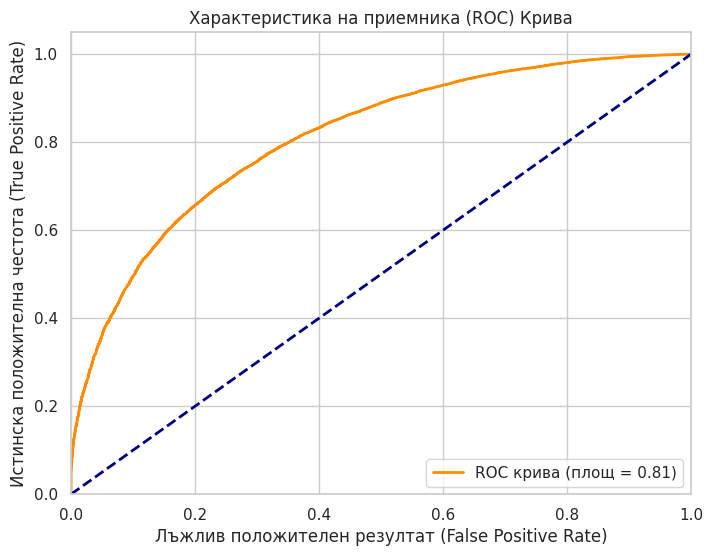

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Предвиждане на вероятности за тестовия набор
y_scores = pipeline.predict_proba(X_test)[:, 1]  # вземете вероятностите за положителния клас

# Изчисляване на ROC крива и площ под кривата (AUC)
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Изобразяване на ROC кривата
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC крива (площ = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Лъжлив положителен резултат (False Positive Rate)')
plt.ylabel('Истинска положителна честота (True Positive Rate)')
plt.title('Характеристика на приемника (ROC) Крива')
plt.legend(loc="lower right")
plt.show()


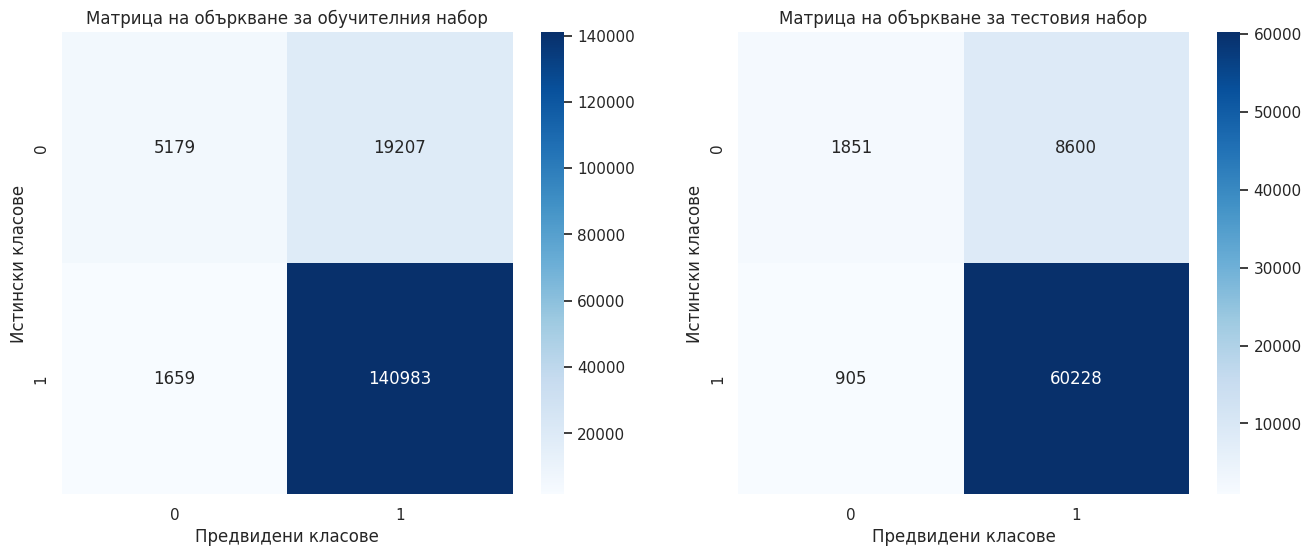

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Предвиждане на маркерите за обучителния набор
y_train_pred = pipeline.predict(X_train)

# Изчисляване на матриците на объркване за обучителния и тестовия набор
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_pred)

# Изобразяване на матриците на объркване
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Матрица на объркване за обучителния набор
sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Предвидени класове')
ax[0].set_ylabel('Истински класове')
ax[0].set_title('Матрица на объркване за обучителния набор')

# Матрица на объркване за тестовия набор
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', ax=ax[1])
ax[1].set_xlabel('Предвидени класове')
ax[1].set_ylabel('Истински класове')
ax[1].set_title('Матрица на объркване за тестовия набор')

plt.show()


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.602767 to fit


<Figure size 5000x5000 with 0 Axes>

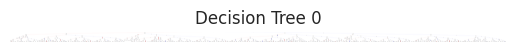

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Get the trained XGBoost model from the pipeline
xgb_model = pipeline.named_steps['classifier']

# Plot the decision tree (you can change tree_num to visualize a different tree)
tree_num = 0
plt.figure(figsize=(50, 50))
xgb.plot_tree(xgb_model, num_trees=tree_num)  # rankdir='LR' for left-to-right orientation
plt.title(f'Decision Tree {tree_num}')
plt.show()

In [ ]:
# Save the image as a file (you can change the filename and format)
plt.savefig('decision_tree.png')

<Figure size 640x480 with 0 Axes>

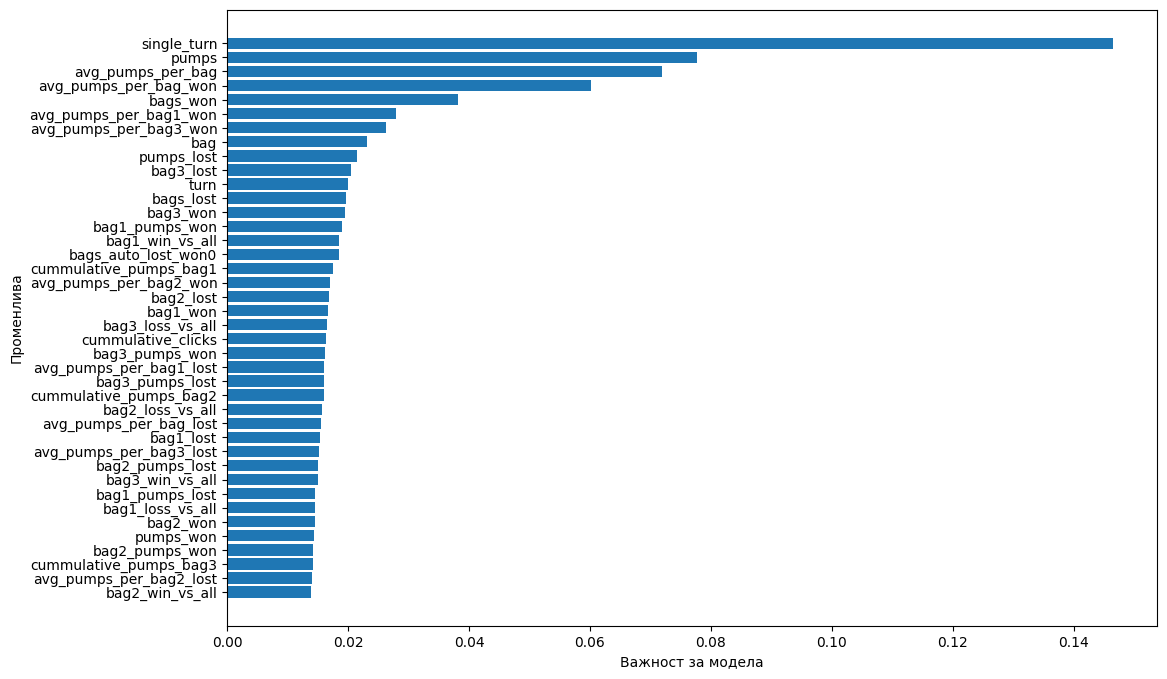

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'optimized_pipeline' is your trained pipeline

# Access the trained XGBClassifier from the pipeline
xgb_classifier = pipeline.named_steps['classifier']

# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Feature names (assuming you have them)
feature_names = X_train.columns

# Pair feature names with their corresponding importances
features = list(zip(feature_names, feature_importances))

# Sort the feature importances in descending order
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# Unzip into separate lists for plotting
sorted_feature_names, sorted_importances = zip(*sorted_features)

# Create a bar chart of the sorted feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Важност за модела')
plt.ylabel('Променлива')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# Final Analysis

In [ ]:
transformed_df['Risk_Probability'] = pipeline.predict_proba(X)[:, 1]

<ipython-input-58-23230cbac0a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df['Risk_Probability'] = pipeline.predict_proba(X)[:, 1]


In [ ]:
transformed_df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3,Risked,Risk_Probability
0,1,0,0,1,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.947957
1,1,0,0,2,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.960223
2,1,0,1,3,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.929561
3,1,0,0,1,3,2,3,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,1,1,0.969013
4,1,0,0,2,3,2,3,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,2,1,0.797100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.960496
407,1269,0,0,9,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.949879
408,1269,0,0,10,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.931097
409,1269,0,0,11,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.923744


In [ ]:
transformed_df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3,Risked,Risk_Probability
0,1,0,0,1,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.947957
1,1,0,0,2,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.960223
2,1,0,1,3,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.929561
3,1,0,0,1,3,2,3,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,1,1,0.969013
4,1,0,0,2,3,2,3,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,2,1,0.797100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.960496
407,1269,0,0,9,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.949879
408,1269,0,0,10,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.931097
409,1269,0,0,11,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.923744


In [ ]:
transformed_df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3,Risked,Risk_Probability
0,1,0,0,1,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.947957
1,1,0,0,2,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.960223
2,1,0,1,3,0,1,2,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.929561
3,1,0,0,1,3,2,3,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,1,1,0.969013
4,1,0,0,2,3,2,3,0,0,0,...,0,0.000000,0.000000,0,0,0.000000,0.000000,2,1,0.797100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.960496
407,1269,0,0,9,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.949879
408,1269,0,0,10,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.931097
409,1269,0,0,11,277,50,2,0,0,0,...,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.923744


In [ ]:
# Adjustment Logic:

# If a player risked where others risked as well (high 'Risked' value and high average risk-taking behavior), their risk-taking score should be adjusted downwards to reflect conformity.
# If a player risked where others didn't (high 'Risked' value but low average risk-taking behavior), their score should be adjusted upwards to reflect higher individual risk-taking.
# If a player did not risk where others did not risk (low 'Risked' value and low average risk-taking behavior), their score remains the same.
# If a player did not risk where others risked (low 'Risked' value but high average risk-taking behavior), their score should be adjusted downwards to reflect lower individual risk-taking.
# Implement the Adjustment

In [ ]:
from sklearn.metrics import roc_curve

# Predict the probabilities for the positive class
y_train_prob = pipeline.predict_proba(X_train)[:, 1]  # Assuming the second column is for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)

# Calculate Youden's J statistic
youden_j = tpr - fpr

# Find the optimal threshold
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)


Optimal Threshold: 0.8392241


In [ ]:
np.sqrt(0.25)

0.5

In [ ]:
import numpy as np  # Make sure to import numpy for the square root operation

def adjust_risk_score_new(row):
    if row['Risked'] == 1:
        if row['Risk_Probability'] <= 0.8392241:
            return row['Risk_Probability'] ** 2
        else:
            return row['Risk_Probability']
    else:
        if row['Risk_Probability'] <=0.8392241:
            return row['Risk_Probability']
        else:
            return np.sqrt(row['Risk_Probability'])

# Assuming transformed_df is your DataFrame
transformed_df['Adjusted_Risk_Score_New'] = transformed_df.apply(adjust_risk_score_new, axis=1)


<ipython-input-64-51213a90ae16>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df['Adjusted_Risk_Score_New'] = transformed_df.apply(adjust_risk_score_new, axis=1)


In [ ]:
transformed_df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3,Risked,Risk_Probability,Adjusted_Risk_Score_New
0,1,0,0,1,0,1,2,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.947957,0.947957
1,1,0,0,2,0,1,2,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.960223,0.960223
2,1,0,1,3,0,1,2,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.929561,0.929561
3,1,0,0,1,3,2,3,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,1,1,0.969013,0.969013
4,1,0,0,2,3,2,3,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,2,1,0.797100,0.635368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.960496,0.960496
407,1269,0,0,9,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.949879,0.949879
408,1269,0,0,10,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.931097,0.931097
409,1269,0,0,11,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.923744,0.923744


In [ ]:
# Squaring High Probability for Risk Takers (Risked = 1, Risk_Probability > 0.5): This emphasizes higher risk behavior in situations where the individual is likely to take risks. Squaring a probability greater than 0.5 increases its value, highlighting the propensity for risk-taking in high-probability scenarios. It's a way to amplify the perception of risk in cases where individuals are already inclined to take risks.

# Keeping Scores Same in Certain Conditions: In cases where individuals took a risk with a low probability (Risked = 1, Risk_Probability < 0.5) or didn't take a risk with a high probability (Risked = 0, Risk_Probability > 0.5), keeping the scores the same implies that these actions are in line with a standard or expected behavior. This suggests a certain balance or moderation in risk behavior.

# Square Root for Non-Risk Takers with Low Probability (Risked = 0, Risk_Probability < 0.5): Taking the square root of the probability when an individual does not take a risk and the probability is low reduces the emphasis on their risk-averse behavior. This can be interpreted as giving less weight to cautious behavior in low-risk situations, possibly to avoid overemphasizing excessive caution.

# Overall, your approach seems to be designed to accentuate risk-taking behavior in high-probability scenarios and moderate it in low-probability scenarios. This could be useful in contexts where understanding the nuances of risk behavior is important, such as in psychological assessments or behavioral economics. However, the effectiveness and appropriateness of this method would depend on the specific goals of your analysis and how well these adjustments align with the real-world behaviors you're trying to model or understand. It's always recommended to validate such an approach with empirical data or expert input in the relevant field.

In [ ]:
0.9**3

0.7290000000000001

In [ ]:
# Group by 'turn' and calculate the mean and confidence interval
grouped = transformed_df.groupby('turn')['Risk_Probability'].agg(['mean', 'sem'])


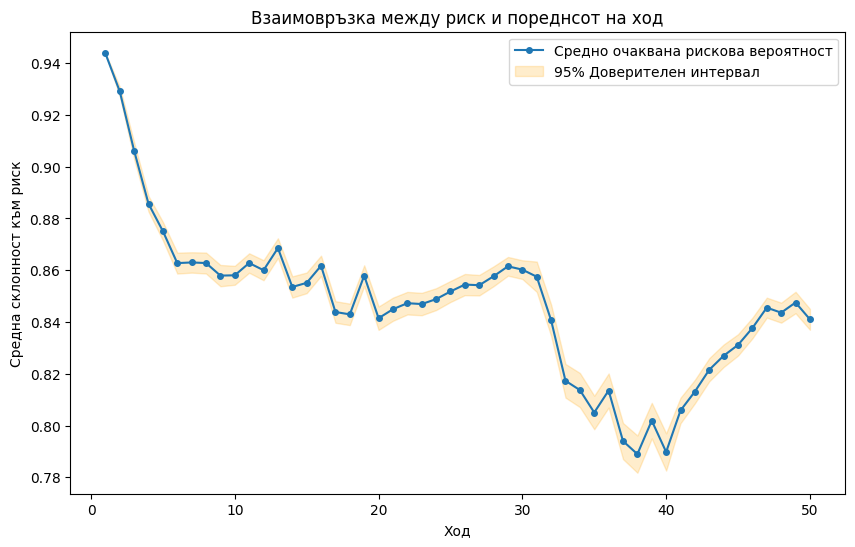

In [ ]:
# Calculate the upper and lower bounds of the confidence interval
grouped['upper_bound'] = grouped['mean'] + 1.96 * grouped['sem']  # 95% confidence interval
grouped['lower_bound'] = grouped['mean'] - 1.96 * grouped['sem']

# Create a shaded area for the confidence interval
plt.figure(figsize=(10, 6))
x = grouped.index  # 'turn' values
y = grouped['mean']  # Mean Risk_Probability values
upper_bound = grouped['upper_bound']
lower_bound = grouped['lower_bound']

plt.plot(x, y, '-o', markersize=4, label='Средно очаквана рискова вероятност')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.2, label='95% Доверителен интервал', color='orange')
plt.xlabel('Ход')
plt.ylabel('Средна склонност към риск')
plt.title('Взаимовръзка между риск и пореднсот на ход')
plt.grid(False)
plt.legend()
plt.show()

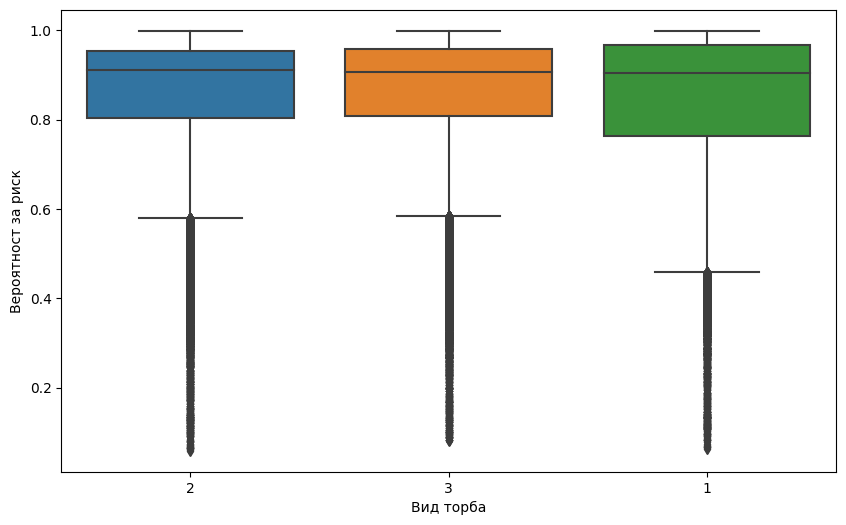

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Load your DataFrame here
# df = pd.read_csv('your_data.csv')

# Create a boxplot per bag
plt.figure(figsize=(10, 6))
sns.boxplot(x='bag', y='Risk_Probability', data=transformed_df)
plt.xlabel('Вид торба')
plt.ylabel('Вероятност за риск')
# plt.title('Boxplot of Risk_Probability per Bag')
plt.grid(False)
plt.show()


KS Statistic: 0.1432739499250021
KS p-value: 3.4836528260763253e-20


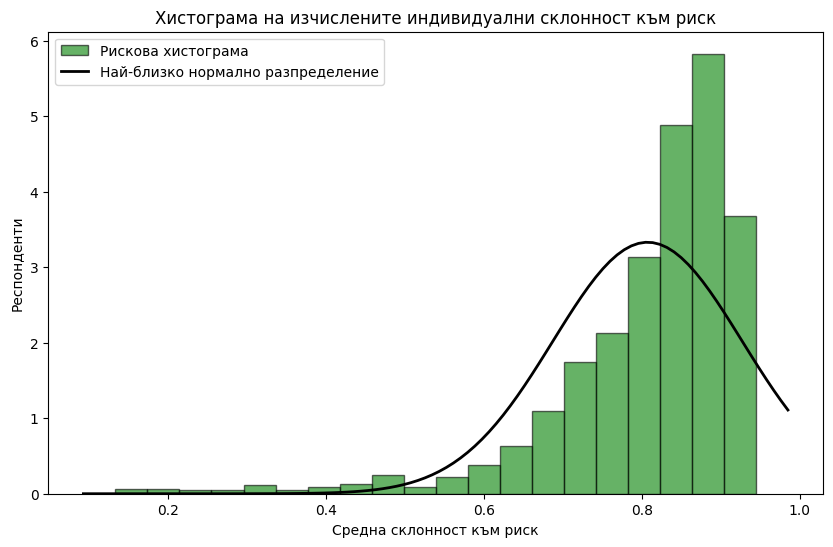

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
import pandas as pd
from scipy.stats import gmean

# Assuming your DataFrame is named 'df'
# Load your DataFrame here
# df = pd.read_csv('your_data.csv')

# Calculate the average Risk_Probability per Id
average_risk_by_id = transformed_df.groupby('Id')['Risk_Probability'].apply(lambda x: gmean(x))

# Fit a normal distribution to the data
mu, std = norm.fit(average_risk_by_id)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(average_risk_by_id, bins=20, density=True, alpha=0.6, color='g', edgecolor='k', label='Рискова хистограма')

# Create a PDF (probability density function) using the fitted parameters
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Най-близко нормално разпределение')

plt.xlabel('Средна склонност към риск')
plt.ylabel('Респонденти')
plt.title('Хистограма на изчислените индивидуални склонност към риск')
plt.grid(False)
plt.legend()

# Perform the KS test
ks_statistic, ks_p_value = kstest(average_risk_by_id, 'norm', args=(mu, std))
print(f'KS Statistic: {ks_statistic}')
print(f'KS p-value: {ks_p_value}')

plt.show()


In [ ]:
df_old = df_start[df_start.index.isin(transformed_df.Id.unique())].reset_index(drop = False)
df_old

,index,collected_1,collected_2,collected_3,collected_4,collected_5,collected_6,collected_7,collected_8,collected_9,...,bag_42,bag_43,bag_44,bag_45,bag_46,bag_47,bag_48,bag_49,bag_50,Id
0,1,0,3,4,0,2,3,3,4,3,...,2,2,2,2,2,2,2,2,2,1
1,2,0,0,0,0,0,0,0,0,6,...,2,2,2,2,2,2,2,2,2,2
2,3,0,3,4,0,0,2,2,2,2,...,2,2,2,2,2,2,2,2,2,3
3,5,0,2,3,0,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,5
4,7,0,3,0,0,0,2,1,2,3,...,2,2,2,2,2,2,2,2,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1263,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,1263
1097,1265,18,0,10,16,0,0,17,0,0,...,2,2,2,2,2,2,2,2,2,1265
1098,1266,14,0,8,0,9,0,0,0,1,...,2,2,2,2,2,2,2,2,2,1266
1099,1267,1,1,1,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,1267


In [ ]:


# Assuming you have 'average_risk_by_id' as a Series
# Create a DataFrame from the Series
average_risk_df = pd.DataFrame({'Id': average_risk_by_id.index, 'Risk_Probability': average_risk_by_id.values})

# Set 'Id' as the index
average_risk_df.set_index('Id', inplace=True)

# Display the resulting DataFrame
average_risk_df.reset_index(drop = False, inplace = True)
average_risk_df.columns = ['index', 'AVG_RISK_PROB']
df_merge  = df_old.merge(average_risk_df, on = 'index', how = 'left')
df_merge['Classic Metric'] = (df_merge.filter(regex = 'collected').sum(axis = 1)) / (df_merge.filter(regex='collected') != 0).astype(int).sum(axis = 1)

In [ ]:
df_merge  = df_old.merge(average_risk_df, on = 'index', how = 'left')
df_merge['Classic Metric'] = (df_merge.filter(regex = 'collected').sum(axis = 1)) / (df_merge.filter(regex='collected') != 0).astype(int).sum(axis = 1)

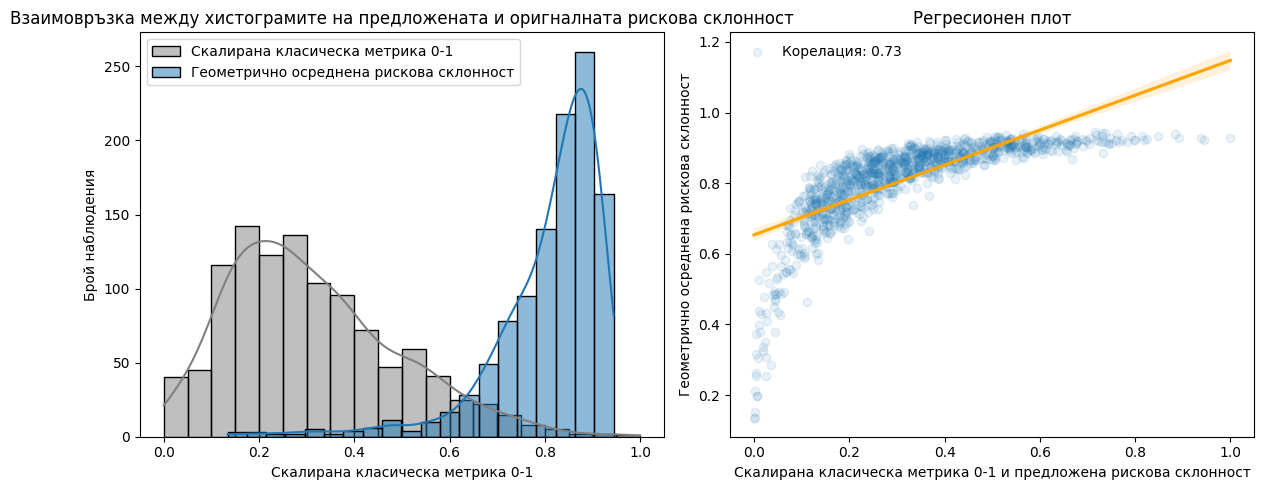

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df_merge'
# Load your DataFrame here
# df_merge = pd.read_csv('your_data.csv')

# Scale the "Classic Metric" to a range of 0 to 1
df_merge['Scaled_Classic_Metric'] = (df_merge['Classic Metric'] - df_merge['Classic Metric'].min()) / (df_merge['Classic Metric'].max() - df_merge['Classic Metric'].min())

# Create a figure with a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot both histograms on the same graph (sharing the same axis) in the left subplot
sns.histplot(df_merge['Scaled_Classic_Metric'], bins=20, kde=True, ax=axes[0], color='grey', label='Скалирана класическа метрика 0-1')
sns.histplot(df_merge['AVG_RISK_PROB'], bins=20, kde=True, ax=axes[0], label='Геометрично осреднена рискова склонност')
axes[0].set_title('Взаимовръзка между хистограмите на предложената и оригналната рискова склонност')
axes[0].legend()
axes[0].set_xlabel('Скалирана класическа метрика 0-1')
axes[0].set_ylabel('Брой наблюдения')

# Create a regression plot on the right subplot with a custom line color (orange)
regplot = sns.regplot(x='Scaled_Classic_Metric', y='AVG_RISK_PROB', data=df_merge, ax=axes[1], line_kws={'color': 'orange'}, scatter_kws={'alpha': 0.1})

# Extract the correlation coefficient from the regression plot
correlation_coefficient = df_merge[['Scaled_Classic_Metric', 'AVG_RISK_PROB']].corr().iloc[0, 1]
correlation_text = f'Корелация: {correlation_coefficient:.2f}'

# Add the correlation information to the legend with the orange line
regplot.legend([correlation_text], loc='upper left', fontsize=10, frameon=False)
regplot.set_xlabel('Скалирана класическа метрика 0-1 и предложена рискова склонност')
regplot.set_ylabel('Геометрично осреднена рискова склонност')

axes[1].set_title('Регресионен плот')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


KS Statistic: 0.09306325980044655
KS p-value: 9.489476657744676e-09


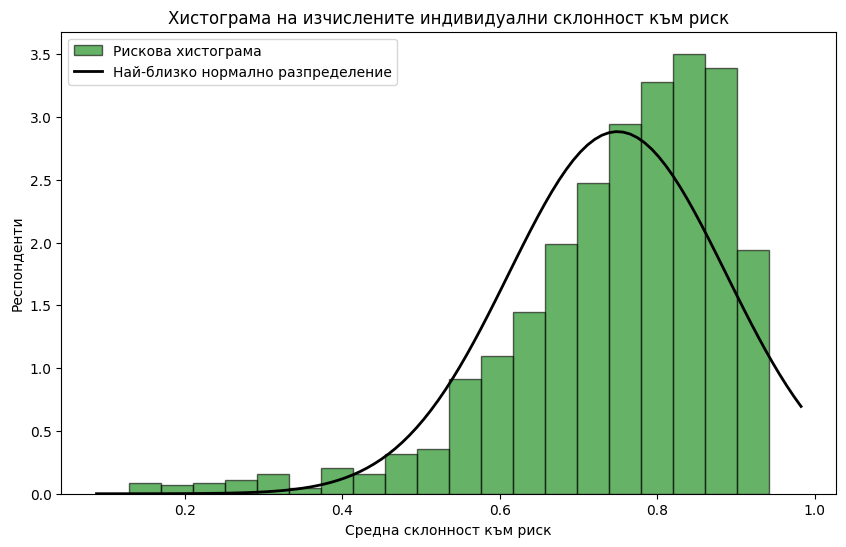

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
import pandas as pd
from scipy.stats import gmean

# Assuming your DataFrame is named 'df'
# Load your DataFrame here
# df = pd.read_csv('your_data.csv')

# Calculate the average Risk_Probability per Id
average_risk_by_id = transformed_df.groupby('Id')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))

# Fit a normal distribution to the data
mu, std = norm.fit(average_risk_by_id)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(average_risk_by_id, bins=20, density=True, alpha=0.6, color='g', edgecolor='k', label='Рискова хистограма')

# Create a PDF (probability density function) using the fitted parameters
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Най-близко нормално разпределение')

plt.xlabel('Средна склонност към риск')
plt.ylabel('Респонденти')
plt.title('Хистограма на изчислените индивидуални склонност към риск')
plt.grid(False)
plt.legend()

# Perform the KS test
ks_statistic, ks_p_value = kstest(average_risk_by_id, 'norm', args=(mu, std))
print(f'KS Statistic: {ks_statistic}')
print(f'KS p-value: {ks_p_value}')

plt.show()


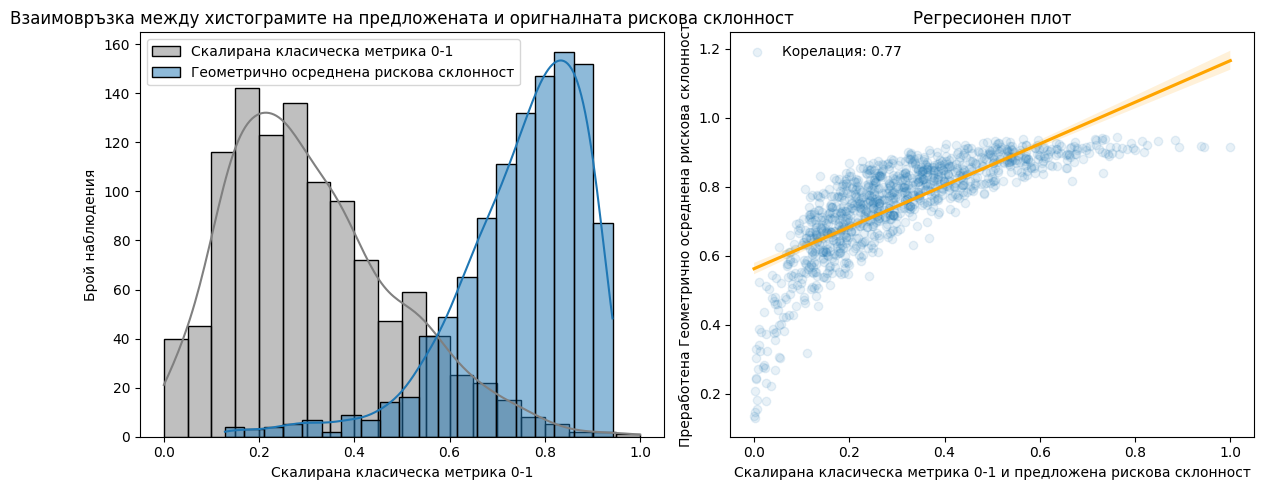

In [ ]:


# Assuming you have 'average_risk_by_id' as a Series
# Create a DataFrame from the Series
average_risk_df = pd.DataFrame({'Id': average_risk_by_id.index, 'Adjusted_Risk_Score_New': average_risk_by_id.values})

# Set 'Id' as the index
average_risk_df.set_index('Id', inplace=True)

# Display the resulting DataFrame
average_risk_df.reset_index(drop = False, inplace = True)
average_risk_df.columns = ['index', 'Adjusted_Risk_Score_New']
df_merge  = df_old.merge(average_risk_df, on = 'index', how = 'left')
df_merge['Classic Metric'] = (df_merge.filter(regex = 'collected').sum(axis = 1)) / (df_merge.filter(regex='collected') != 0).astype(int).sum(axis = 1)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df_merge'
# Load your DataFrame here
# df_merge = pd.read_csv('your_data.csv')

# Scale the "Classic Metric" to a range of 0 to 1
df_merge['Scaled_Classic_Metric'] = (df_merge['Classic Metric'] - df_merge['Classic Metric'].min()) / (df_merge['Classic Metric'].max() - df_merge['Classic Metric'].min())

# Create a figure with a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot both histograms on the same graph (sharing the same axis) in the left subplot
sns.histplot(df_merge['Scaled_Classic_Metric'], bins=20, kde=True, ax=axes[0], color='grey', label='Скалирана класическа метрика 0-1')
sns.histplot(df_merge['Adjusted_Risk_Score_New'], bins=20, kde=True, ax=axes[0], label='Геометрично осреднена рискова склонност')
axes[0].set_title('Взаимовръзка между хистограмите на предложената и оригналната рискова склонност')
axes[0].legend()
axes[0].set_xlabel('Скалирана класическа метрика 0-1')
axes[0].set_ylabel('Брой наблюдения')

# Create a regression plot on the right subplot with a custom line color (orange)
regplot = sns.regplot(x='Scaled_Classic_Metric', y='Adjusted_Risk_Score_New', data=df_merge, ax=axes[1], line_kws={'color': 'orange'}, scatter_kws={'alpha': 0.1})

# Extract the correlation coefficient from the regression plot
correlation_coefficient = df_merge[['Scaled_Classic_Metric', 'Adjusted_Risk_Score_New']].corr().iloc[0, 1]
correlation_text = f'Корелация: {correlation_coefficient:.2f}'

# Add the correlation information to the legend with the orange line
regplot.legend([correlation_text], loc='upper left', fontsize=10, frameon=False)
regplot.set_xlabel('Скалирана класическа метрика 0-1 и предложена рискова склонност')
regplot.set_ylabel('Преработена Геометрично осреднена рискова склонност')

axes[1].set_title('Регресионен плот')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
average_risk_by_id

Id
1       0.659578
2       0.829209
3       0.625999
5       0.551339
7       0.622522
          ...   
1263    0.834720
1265    0.883955
1266    0.726789
1267    0.452904
1269    0.893026
Name: Adjusted_Risk_Score_New, Length: 1101, dtype: float64

In [ ]:
transformed_df

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3,Risked,Risk_Probability,Adjusted_Risk_Score_New
0,1,0,0,1,0,1,2,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.947957,0.947957
1,1,0,0,2,0,1,2,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.960223,0.960223
2,1,0,1,3,0,1,2,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,0,1,0.929561,0.929561
3,1,0,0,1,3,2,3,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,1,1,0.969013,0.969013
4,1,0,0,2,3,2,3,0,0,0,...,0.000000,0.000000,0,0,0.000000,0.000000,2,1,0.797100,0.635368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.960496,0.960496
407,1269,0,0,9,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.949879,0.949879
408,1269,0,0,10,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.931097,0.931097
409,1269,0,0,11,277,50,2,0,0,0,...,0.608696,0.142857,169,28,12.071429,9.333333,197,1,0.923744,0.923744


In [ ]:
# Segment the DataFrame
df_turn1_20 = transformed_df[transformed_df['turn'].between(1, 20)]
df_turn21_50 = transformed_df[transformed_df['turn'].between(21, 50)]


# Compute the metrics for each segment
metrics_turn1_20 = df_turn1_20.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()
metrics_turn21_50 = df_turn21_50.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()

# Combine the results
combined_metrics = metrics_turn1_20.join(metrics_turn21_50, lsuffix='_turn1_20', rsuffix='_turn21_50')

<ipython-input-80-1cb6d197aae9>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  metrics_turn1_20 = df_turn1_20.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()
<ipython-input-80-1cb6d197aae9>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  metrics_turn21_50 = df_turn21_50.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()


In [ ]:
combined_metrics

,Risk_Probability_turn1_20,Adjusted_Risk_Score_New_turn1_20,Risk_Probability_turn21_50,Adjusted_Risk_Score_New_turn21_50
Id,,,,
1,0.802914,0.773006,0.721816,0.680605
2,0.871473,0.839798,0.881415,0.844015
3,0.731977,0.682548,0.747297,0.695254
5,0.688563,0.674078,0.677081,0.596879
7,0.732693,0.675412,0.745661,0.701264
...,...,...,...,...
1263,0.861013,0.798378,0.901622,0.875152
1265,0.913523,0.906781,0.892965,0.875888
1266,0.824600,0.781034,0.806189,0.748844


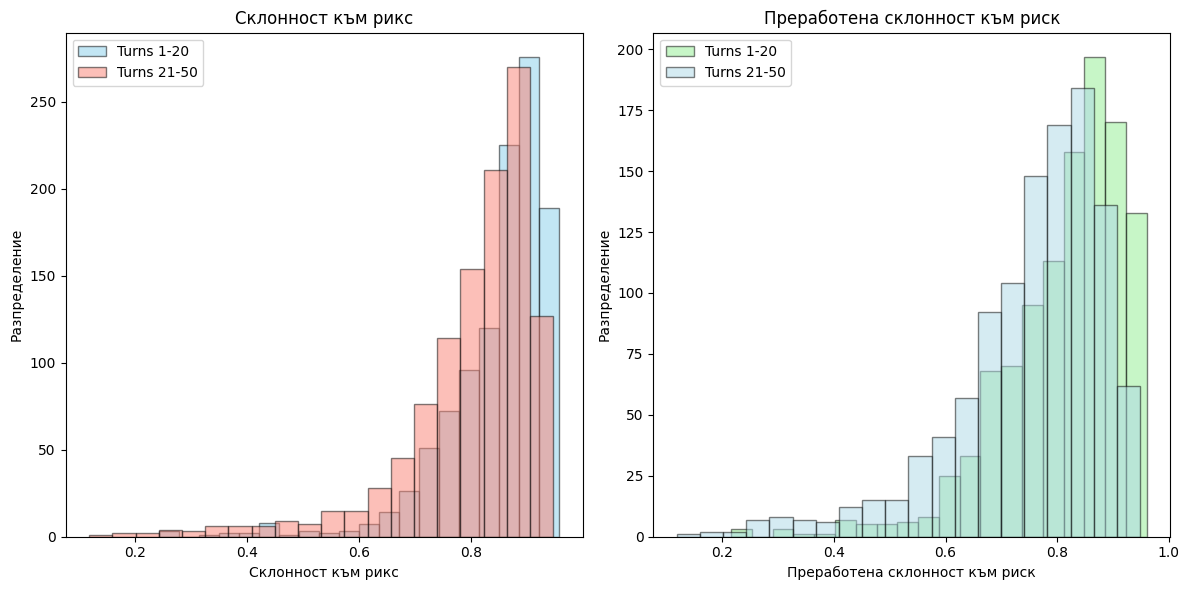

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histograms for Risk Probability
axs[0].hist(combined_metrics['Risk_Probability_turn1_20'], bins=20, color='skyblue', edgecolor='black', alpha=0.5, label='Turns 1-20')
axs[0].hist(combined_metrics['Risk_Probability_turn21_50'], bins=20, color='salmon', edgecolor='black', alpha=0.5, label='Turns 21-50')
axs[0].set_title('Склонност към рикс')
axs[0].set_xlabel('Склонност към рикс')
axs[0].set_ylabel('Разпределение')
axs[0].legend()

# Plot histograms for Adjusted Risk Score
axs[1].hist(combined_metrics['Adjusted_Risk_Score_New_turn1_20'], bins=20, color='lightgreen', edgecolor='black', alpha=0.5, label='Turns 1-20')
axs[1].hist(combined_metrics['Adjusted_Risk_Score_New_turn21_50'], bins=20, color='lightblue', edgecolor='black', alpha=0.5, label='Turns 21-50')
axs[1].set_title('Преработена склонност към риск')
axs[1].set_xlabel('Преработена склонност към риск')
axs[1].set_ylabel('Разпределение')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

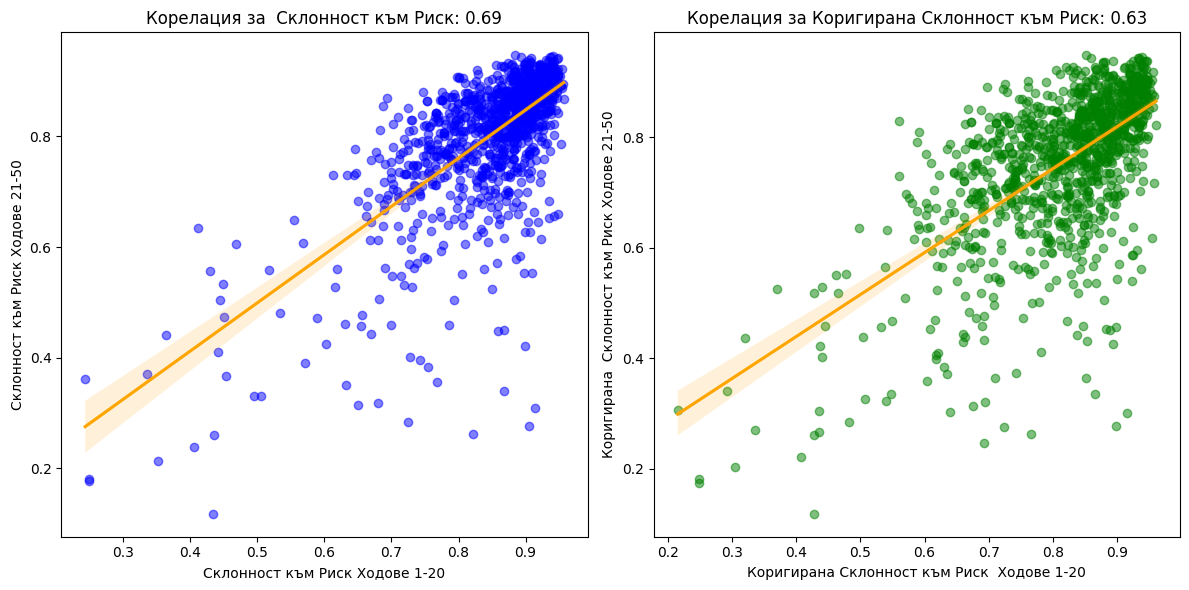

In [ ]:
# Изчисляване на корелационни стойности
corr_risk_prob = combined_metrics['Risk_Probability_turn1_20'].corr(combined_metrics['Risk_Probability_turn21_50'])
corr_adj_risk_score = combined_metrics['Adjusted_Risk_Score_New_turn1_20'].corr(combined_metrics['Adjusted_Risk_Score_New_turn21_50'])

# Създаване на 1x2 графики за разсейване с корелационни стойности и оранжеви линии на регресия

# Създаване на графики
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Графика за Риск вероятност с корелация в заглавие и оранжева линия на регресия
sns.regplot(ax=axs[0], x='Risk_Probability_turn1_20', y='Risk_Probability_turn21_50', data=combined_metrics, color='blue', scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'})
axs[0].set_title(f'Корелация за  Склонност към Риск: {corr_risk_prob:.2f}')
axs[0].set_xlabel('Склонност към Риск Ходове 1-20')
axs[0].set_ylabel('Склонност към Риск Ходове 21-50')

# Графика за Коригиран Риск Стойност с корелация в заглавие и оранжева линия на регресия
sns.regplot(ax=axs[1], x='Adjusted_Risk_Score_New_turn1_20', y='Adjusted_Risk_Score_New_turn21_50', data=combined_metrics, color='green', scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'})
axs[1].set_title(f'Корелация за Коригирана Склонност към Риск: {corr_adj_risk_score:.2f}')
axs[1].set_xlabel('Коригиранa Склонност към Риск  Ходове 1-20')
axs[1].set_ylabel('Коригиранa  Склонност към Риск Ходове 21-50')

# Подреди графиките
plt.tight_layout()
plt.show()

In [ ]:
# Assuming your DataFrame is named 'df'
# Filter the data for bag 1, bag 2, and bag 3 separately
bag1_data = transformed_df[transformed_df['bag'].astype(int) == 1]
bag2_data = transformed_df[transformed_df['bag'].astype(int) == 2]
bag3_data = transformed_df[transformed_df['bag'].astype(int) == 3]

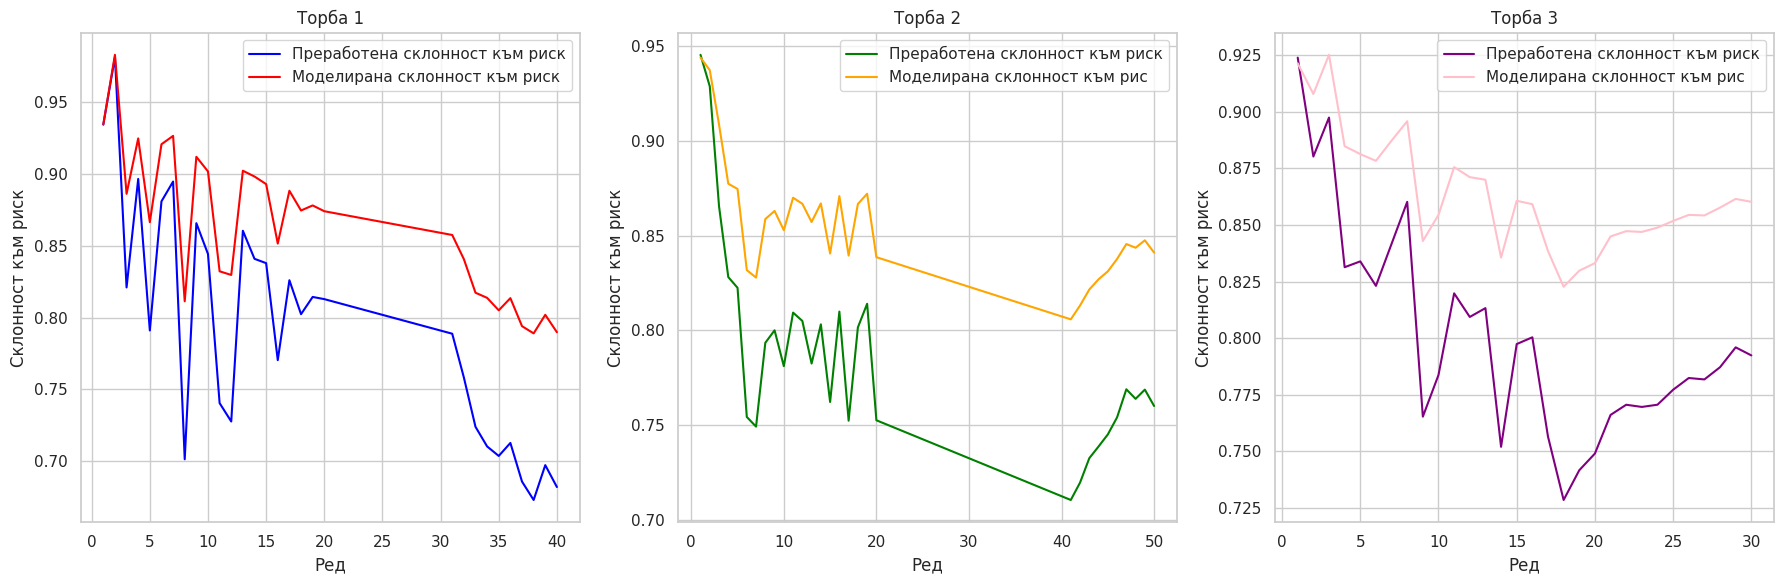

In [ ]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate and plot the gmean for Bag 1
gmean_bag1 = bag1_data.groupby('turn')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))
axes[0].plot(gmean_bag1.index, gmean_bag1.values, label='Преработена склонност към риск', color='blue')
axes[0].set_xlabel('Ред')
axes[0].set_ylabel('Склонност към риск')
axes[0].set_title('Торба 1')
axes[0].legend(loc='upper right')

# Add a line for Risk_Probability (assuming it's a column in your DataFrame)
axes[0].plot(gmean_bag1.index, bag1_data.groupby('turn')['Risk_Probability'].mean(), label='Моделирана склонност към риск', color='red')
axes[0].legend(loc='upper right')

# Calculate and plot the gmean for Bag 2
gmean_bag2 = bag2_data.groupby('turn')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))
axes[1].plot(gmean_bag2.index, gmean_bag2.values, label='Преработена склонност към риск', color='green')
axes[1].set_xlabel('Ред')
axes[1].set_ylabel('Склонност към риск')
axes[1].set_title('Торба 2')
axes[1].legend(loc='upper right')

# Add a line for Risk_Probability (assuming it's a column in your DataFrame)
axes[1].plot(gmean_bag2.index, bag2_data.groupby('turn')['Risk_Probability'].mean(), label='Моделирана склонност към рис', color='orange')
axes[1].legend(loc='upper right')

# Calculate and plot the gmean for Bag 3
gmean_bag3 = bag3_data.groupby('turn')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))
axes[2].plot(gmean_bag3.index, gmean_bag3.values, label='Преработена склонност към риск', color='purple')
axes[2].set_xlabel('Ред')
axes[2].set_ylabel('Склонност към риск')
axes[2].set_title('Торба 3')
axes[2].legend(loc='upper right')

# Add a line for Risk_Probability (assuming it's a column in your DataFrame)
axes[2].plot(gmean_bag3.index, bag3_data.groupby('turn')['Risk_Probability'].mean(), label='Моделирана склонност към рис', color='pink')
axes[2].legend(loc='upper right')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()


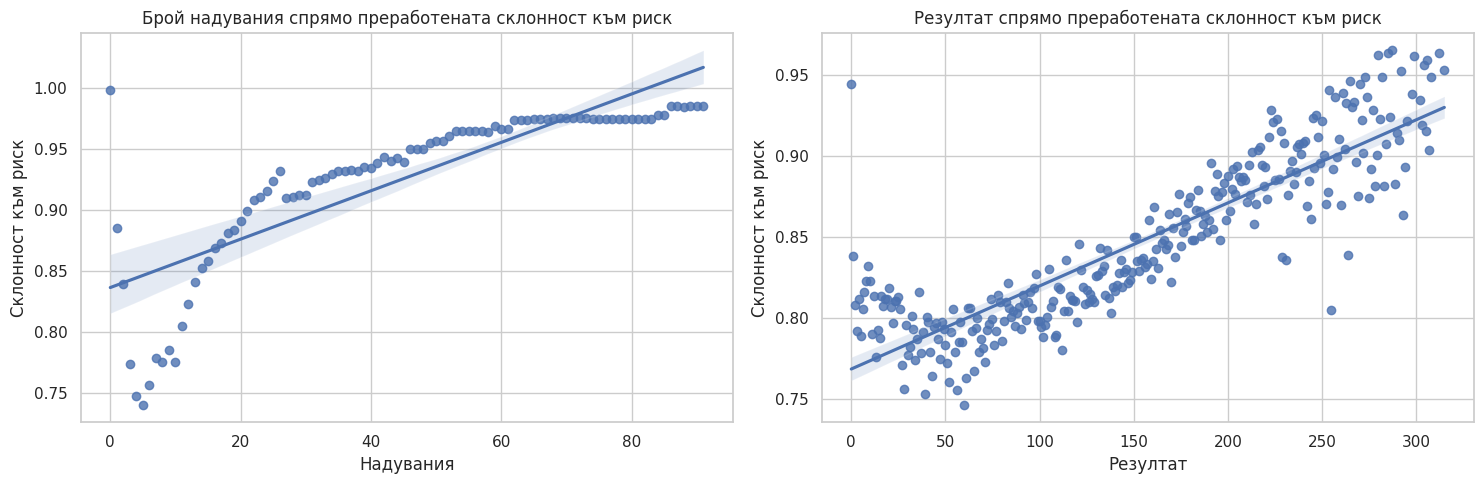

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming your DataFrame is named 'df'
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Group the data by 'pumps' and calculate the geometric mean for 'Adjusted_Risk_Score_New'
aggregated_df = transformed_df.groupby('pumps')['Adjusted_Risk_Score_New'].agg(geo_mean=np.nanmean).reset_index()

# Create the first regplot between 'pumps' and 'Adjusted_Risk_Score_New'
sns.regplot(x="pumps", y="geo_mean", data=aggregated_df, ax=axes[0])
axes[0].set_title("Брой надувания спрямо преработената склонност към риск")
axes[0].set_xlabel("Надувания")
axes[0].set_ylabel("Склонност към риск")

# Group the data by 'total' and calculate the geometric mean for 'Adjusted_Risk_Score_New'
aggregated_df2 = transformed_df.groupby('total')['Adjusted_Risk_Score_New'].agg(geo_mean=np.nanmean).reset_index()

# Create the second regplot between 'total' and 'Adjusted_Risk_Score_New'
sns.regplot(x="total", y="geo_mean", data=aggregated_df2, ax=axes[1])
axes[1].set_title("Резултат спрямо преработената склонност към риск")
axes[1].set_xlabel("Резултат")
axes[1].set_ylabel("Склонност към риск")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()
